# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [28]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from ipywidgets import interact, FloatSlider

sns.set_style('darkgrid')

---

**Goal:**  
In this project, we aim to hard-code a function that simulates stock price paths under the Heston model, compute the price of a European call option using Monte Carlo simulations (while highlighting several limitations of this approach), and demonstrate that the Delta for call options is approximately the same under both the Heston and Black-Scholes models. This suggests that the same Delta-hedging strategy used in Black-Scholes pricing may also be applicable in the Heston framework.

---

# Heston Model Simulation

We begin by defining the following variables:

- $S(t)$: Price of the stock at time $t$  
- $v(t)$: Instantaneous variance (i.e., volatility squared) at time $t$  
- $r$: Risk-free interest rate  
- $\kappa$: Mean-reversion speed of the variance process  
- $\theta$: Long-run mean of the variance  
- $\sigma$: Volatility of volatility (vol-of-vol)  
- $\rho$: Correlation coefficient between Brownian motions  
- $dW_t^{(1)}, dW_t^{(2)}$: Two Wiener processes such that:

$$
dW_t^{(1)} \cdot dW_t^{(2)} = \rho \, dt
$$

The stochastic differential equations (SDEs) that define the Heston model are:

$$
\begin{aligned}
dS(t) &= r S(t) \, dt + \sqrt{v(t)} S(t) \, dW_t^{(1)} \\
dv(t) &= \kappa \left( \theta - v(t) \right) \, dt + \sigma \sqrt{v(t)} \, dW_t^{(2)}
\end{aligned}
$$

From stochastic calculus, it follows that the solution for the stock price is:

$$
S(t) = S(0)\cdot \exp\left( \int_0^t \left( r - \frac{1}{2}v(s) \right) ds + \int_0^t \sqrt{v(s)} \, dW_s^{(1)} \right)
$$

Note that this expression depends on the entire path of \( v(s) \), which has **no closed-form solution**. Therefore, to simulate a stock path, we must simulate $v(s)$ numerically.

Using the Euler-Maruyama approximation, we discretize the SDE for variance as:

$$
v(t + \Delta t) \approx v(t) + \kappa(\theta - v(t))\Delta t + \sigma \sqrt{v(t)} \, \Delta W_t^{(2)}
$$

Since $W_t^{(2)}$ is a Wiener process, its increments are distributed as:

$$
\Delta W_t^{(2)} \sim \mathcal{N}(0, \Delta t)
$$

Finally, to simulate **correlated Brownian increments**, we use:

$$
\Delta W_t^{(1)} = \rho \Delta W_t^{(2)} + \sqrt{1 - \rho^2} \cdot \mathcal{N}(0,1) \cdot \sqrt{\Delta t}
$$

where the standard normal variable $\mathcal{N}(0,1)$ is independent of $\Delta W_t^{(2)}$.


In [7]:
def stock_paths_Heston(S0, V0, t, r, kappa, theta, sigma, rho, n_paths, n_steps):
    '''
    Generation of stock paths following Heston model.
    
    Inputs:
    S0 (float): initial stock value
    V0 (float): initial volatility value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    kappa (float): mean-reversion speed of the variance process
    theta (float): Long-run mean of the variance
    sigma (float): Volatility of volatility
    rho: Correlation Coefficients between Brownian motions
    n_paths (int): number of stock paths
    n_steps (int): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''

    # Set up time increments

    dt = t/n_steps
    
    # Noise in volatility and stock path
    v_noise = np.random.normal(0,dt,size = (n_paths, n_steps))
    s_noise = rho*v_noise + np.sqrt(1-rho**2)*np.random.normal(0,1,size = (n_paths, n_steps))*np.sqrt(dt)

    # Initialize volatility and stock path arrays
    v = np.zeros((n_paths, n_steps+1))
    s = np.zeros((n_paths, n_steps+1))
    v[:,0] = V0
    s[:,0] = S0


    # Simulation 
    for i in range(1,n_steps+1):
        v[:,i] = np.maximum(v[:,i-1] + kappa*(theta - v[:,i-1])*dt + sigma*np.sqrt(dt)*v_noise[:,i-1],0)
        s[:,i] = s[:,i-1]*np.exp((r - 0.5*v[:,i])*dt + np.sqrt(v[:,i])*s_noise[:,i-1])
    
    return s
    

Below is a visualization of the simulation.

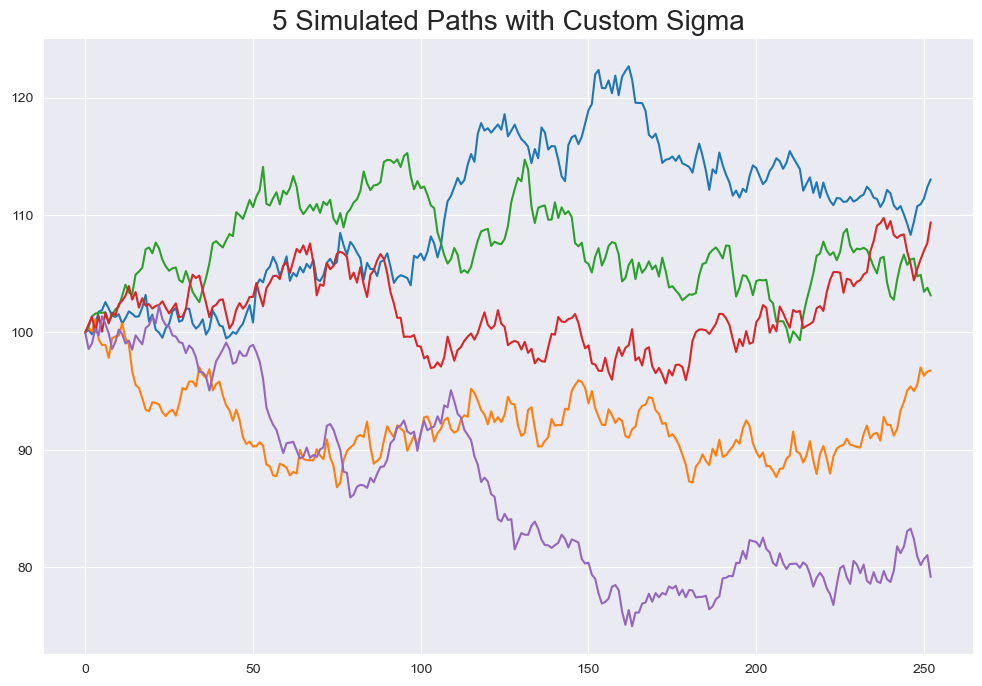

In [8]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
V0 = 0.04
t = 1
r = 0.039
kappa = 2
theta = 0.04
sigma = 0.3
rho = -0.7

n_paths = 5
n_steps = 252


simulated_paths = stock_paths_Heston(S0, V0, t, r, kappa, theta, sigma, rho, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

# Simulated Expected Value

We next run a Monte Carlo simulation to find what the value of an option contract with strike price $K$ should be.

In [9]:

for i in range(0,4):
    K = 110
    n_paths = 100*(10**i)
    simulated_paths = stock_paths_Heston(S0, V0, t, r, kappa, theta, sigma, rho, n_paths, n_steps)
    option_value = np.exp(-r*t)*np.mean(np.maximum(simulated_paths[:,-1] - K, 0))

    print(f'After {n_paths} simulations, the observed expected value is {option_value:.2f}')
    print('-----'*15)

After 100 simulations, the observed expected value is 2.47
---------------------------------------------------------------------------
After 1000 simulations, the observed expected value is 2.83
---------------------------------------------------------------------------
After 10000 simulations, the observed expected value is 2.99
---------------------------------------------------------------------------
After 100000 simulations, the observed expected value is 3.02
---------------------------------------------------------------------------


For completeness, we compare these values with the Black-Scholes price. 

In [10]:
def bs_call(S, K, sigma, T, r=0):
    if np.any(T == 0) or sigma == 0:
        return np.maximum(S - K, 0.0)
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

print(f'The Black-Scholes price of the option contract with the same parameters is {bs_call(S0, K, np.sqrt(V0), t, r):.2f}')

The Black-Scholes price of the option contract with the same parameters is 5.62


We observe a significant difference in option prices between the models. This highlights the sensitivity of pricing to modeling assumptions, and in particular, the limitations of the Black-Scholes model in capturing real-world features such as stochastic volatility and volatility skew.

# Hedging Option Contracts Using the Heston Model

As the underlying model for the stock path movements has changed from geometric Brownian motion to the Heston model, so too will the price of the call options. The "exact" value of a contract is an integral without a closed form solution, but can be numerically approximated by the following formula:

$$
C(S_0, K, t) = S_0 P_1 - K e^{-rt} P_2,
$$

where:

$$
P_j = \frac{1}{2} + \frac{1}{\pi} \int_0^\infty \text{Re} \left[ \frac{e^{-i u \ln K} \phi_j(u)}{i u} \right] du ,\quad j = 1,2
$$

where $\phi_j(u) = \mathbb{E} \left[ e^{i u \ln S_t} \right]$. This derivation is quite intense and is done in full in a paper by Heston from 1993 ([See here](https://doi.org/10.1111/j.1540-6261.1993.tb04709.x)). Given that, we'll simulate the Delta using a Monte Carlo simulation and compare it to the Black-Scholes Delta. The code below estimates the delta numerically.


In [27]:
K = 110

for i in range(0,4):
    n_paths = 100*(10**i)
    h = 1

    # Set a seed for consistency

    np.random.seed(5418167)

    # Left and right perturbations of the stock price

    simulated_paths_l = stock_paths_Heston(S0-h, V0, t, r, kappa, theta, sigma, rho, n_paths, n_steps)
    simulated_paths_r = stock_paths_Heston(S0+h, V0, t, r, kappa, theta, sigma, rho, n_paths, n_steps)

    # Left and right perturbations of the option value

    option_value_l = np.exp(-r*t)*np.mean(np.maximum(simulated_paths_l[:,-1] - K, 0))
    option_value_r = np.exp(-r*t)*np.mean(np.maximum(simulated_paths_r[:,-1] - K, 0))

    Delta_approx = (option_value_r - option_value_l)/(2*h)

    print(f'After {n_paths} simulations, the observed Delta is {Delta_approx:.2f}')
    print('-----'*15)

After 100 simulations, the observed Delta is 0.60
---------------------------------------------------------------------------
After 1000 simulations, the observed Delta is 0.41
---------------------------------------------------------------------------
After 10000 simulations, the observed Delta is 0.33
---------------------------------------------------------------------------
After 100000 simulations, the observed Delta is 0.35
---------------------------------------------------------------------------


The Black-Scholes value of the Delta is given below.

In [36]:
def delta_call(S, K, sigma, T, r=0):
    if np.any(T == 0) or sigma == 0:
        return np.maximum(S - K, 0.0)
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

print(f'The Delta of the Black-Scholes price of the option contract with the same parameters is {delta_call(S0, K, np.sqrt(V0), t, r):.2f}')

The Delta of the Black-Scholes price of the option contract with the same parameters is 0.43


We observe that the Delta is close for this set of parameters. However, this doesn't say much about the Delta when we vary the parameters. Thus, the following code constructs a plot that allows one to vary the parameters and returns a plot that visualizes the difference between the two Deltas.

In [44]:
# Delta of the Heston Model
def heston_delta(S0, K, T, r, V0, kappa, theta, sigma, rho, h=1.0, n_paths=10000, n_steps=250):

    np.random.seed(54167)
    
    simulated_paths_l = stock_paths_Heston(S0-h, V0, t, r, kappa, theta, sigma, rho, n_paths, n_steps)
    simulated_paths_r = stock_paths_Heston(S0+h, V0, t, r, kappa, theta, sigma, rho, n_paths, n_steps)
    
    payoff_l = np.maximum(simulated_paths_l[:, -1] - K, 0)
    payoff_r = np.maximum(simulated_paths_r[:, -1] - K, 0)

    price_l = np.exp(-r*T) * np.mean(payoff_l)
    price_r = np.exp(-r*T) * np.mean(payoff_r)
    
    delta = (price_r - price_l) / (2 * h)
    return delta

# Plot
def plot_deltas(K, kappa, theta, sigma, rho, V0):
    S_range = np.linspace(80, 140, 10)
    T = 1.0
    r = 0.0
    bs_sigma = np.sqrt(V0)

    heston_deltas = []
    bs_deltas = []

    for S in S_range:
        h_delta = heston_delta(S, K, T, r, V0, kappa, theta, sigma, rho)
        b_delta = delta_call(S, K, bs_sigma, t, r)
        heston_deltas.append(h_delta)
        bs_deltas.append(b_delta)

    width = 1.5
    plt.figure(figsize=(10,6))
    plt.bar(S_range - width/2, heston_deltas, width=width, label='Heston Delta', alpha=0.6, color='blue')
    plt.bar(S_range + width/2, bs_deltas, width=width, label='Black-Scholes Delta', alpha=0.6, color='orange')
    plt.xlabel('Spot Price $S_0$')
    plt.ylabel('Delta')
    plt.title('Delta Comparison: Heston vs Black-Scholes')
    plt.legend()
    plt.grid(True)
    plt.show()

# Sliders
interact(plot_deltas,
         K=FloatSlider(min=80, max=160, step=1, value=110),
         kappa=FloatSlider(min=0.1, max=5.0, step=0.1, value=2.0),
         theta=FloatSlider(min=0.01, max=0.5, step=0.01, value=0.04),
         sigma=FloatSlider(min=0.1, max=2.0, step=0.1, value=0.3),
         rho=FloatSlider(min=-0.99, max=0.0, step=0.05, value=-0.5),
         V0=FloatSlider(min=0.01, max=0.5, step=0.01, value=0.04))

interactive(children=(FloatSlider(value=110.0, description='K', max=160.0, min=80.0, step=1.0), FloatSlider(va…

<function __main__.plot_deltas(K, kappa, theta, sigma, rho, V0)>

The sliders reveal that as the option becomes deeper in the money, the delta under the Heston model tends to increase slightly more than in the Black-Scholes model. This behavior is favorable for delta hedging, as allocating slightly more to the underlying asset when its value grows helps maintain hedge effectiveness. More importantly, the two deltas remain consistently close across a range of parameters. This leads to a key insight: when delta hedging under the Heston model, it is often sufficient to use the delta from the Black-Scholes model. This is much faster than trying to simulate the Delta of the Heston model each time.

# Conclusion

In this project, our goal was to develop a delta hedging strategy using the Heston model. We began by simulating stock price paths under the Heston framework, then computed option prices based on those paths. Using these prices, we approximated the delta of the Heston model via Monte Carlo methods. By comparing these values to the analytical delta from the Black-Scholes model, we observed that the two remain close across a range of parameters. This suggests that, for practical purposes, the Black-Scholes delta can be used as an effective proxy when hedging under the Heston model—offering a much faster alternative to repeated Monte Carlo estimation.

# Q&A

### Question: Why didn't you use numerical integration techniques to compute the actual value of the option contract?

While the Monte Carlo approach used in this project is slower than numerically integrating the semi-analytical Heston pricing formula, it offered a much faster development process and clearly illustrated the key idea. Moreover, implementing the numerical integration would have been more complex and less transparent. Overall, the Monte Carlo method was chosen for its simplicity and clarity, even at the cost of computational efficiency.

---